In [40]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [41]:
# image_dir = Path('Final_Normal')

### Create File DataFrame

In [42]:
images = pd.read_excel('Normal.xlsx')

In [43]:
images.head(3)

,Path,Age
0,Final_Normal/00011419.png,80
1,Final_Normal/00018693.png,63
2,Final_Normal/00028236.png,70


In [44]:
images['Path'] = images['Path'].astype(str)

In [45]:
# images['Age'] = images['Age'].astype(str)

In [46]:
images.dtypes

Path    object
Age      int64
dtype: object

In [47]:
len(images)

708

In [48]:
# filepaths = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)

In [49]:
# ages = pd.read_csv('Final_Normal/Age.csv')

In [50]:
# images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [51]:
# images.shape

In [52]:
# images.to_csv('test.csv')

In [53]:
# Let's only use 5000 images to speed up training time
image_df = images.sample(708, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

### Loading Images

In [54]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    width_shift_range = 20,
    height_shift_range = 20,
    horizontal_flip = False,
    fill_mode = "nearest",
    zca_whitening = True,
    zca_epsilon = 1e-06,
    channel_shift_range = 13
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

C:\Users\neudo\anaconda3\lib\site-packages\keras\preprocessing\image.py:1285: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [55]:
train_df.shape

(495, 2)

In [56]:
test_df.shape

(213, 2)

In [57]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Age',
    target_size=(120, 120),
    class_mode='raw',
    batch_size=32,
#     shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Age',
    target_size=(120, 120),
    class_mode='raw',
    batch_size=32,
#     shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Age',
    target_size=(120, 120),
    class_mode='raw',
    batch_size=32,
#     shuffle=False
)

Found 346 validated image filenames.
Found 148 validated image filenames.
Found 213 validated image filenames.


C:\Users\neudo\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


### Training

In [85]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam 

inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer= Adam(lr=0.001),
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

C:\Users\neudo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\neudo\anaconda3\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\neudo\anaconda3\lib\site-packages\keras\preprocessing\image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/300
11/11 [==============================] - 5s 418ms/step - loss: 5086.9131 - val_loss: 4700.4897
Epoch 2/300
11/11 [==============================] - 4s 383ms/step - loss: 5032.9219 - val_loss: 4601.2954
Epoch 3/300
11/11 [==============================] - 4s 381ms/step - loss: 4906.0063 - val_loss: 4605.7998
Epoch 4/300
11/11 [==============================] - 4s 387ms/step - loss: 4643.6523 - val_loss: 4294.4058
Epoch 5/300
11/11 [==============================] - 4s 388ms/step - loss: 4225.1631 - val_loss: 3909.5977
Epoch 6/300
11/11 [==============================] - 4s 385ms/step - loss: 3575.5234 - val_loss: 3364.5601
Epoch 7/300
11/11 [==============================] - 4s 383ms/step - loss: 2807.9597 - val_loss: 2534.4207
Epoch 8/300
11/11 [==============================] - 4s 387ms/step - loss: 2028.7466 - val_loss: 1422.3344
Epoch 9/300
11/11 [==============================] - 4s 381ms/step - loss: 1462.2485 - val_loss: 607.8536
Epoch 10/300
11/11 [==================

In [86]:
from sklearn import metrics
from sklearn.metrics import r2_score

predictions = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

mae = metrics.mean_absolute_error(true_ages, predictions)
print('MAE: %.3f' % mae)
mse = metrics.mean_squared_error(true_ages, predictions)
print('MSE: %.3f' % mse)
r2 = r2_score(true_ages, predictions)
print('R2: %.3f' % r2)

7/7 [==============================] - 1s 122ms/step
MAE: 7.477
MSE: 84.035
R2: -0.066


In [87]:
null_rmse = np.sqrt(np.sum((true_ages - np.mean(true_ages))**2) / len(true_ages))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 8.87705


### 

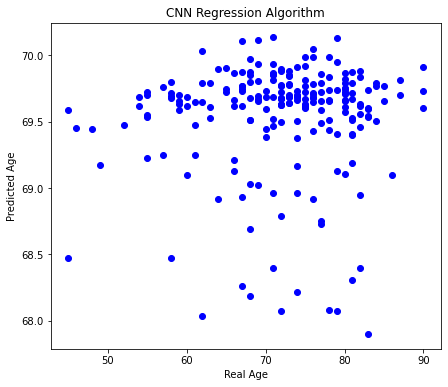

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
ax = plt.scatter(true_ages, predictions, color = 'blue')
plt.title('CNN Regression Algorithm')
plt.xlabel('Real Age')
plt.ylabel('Predicted Age')
fig = ax.get_figure()
fig.savefig('BRcatterPlot.png')

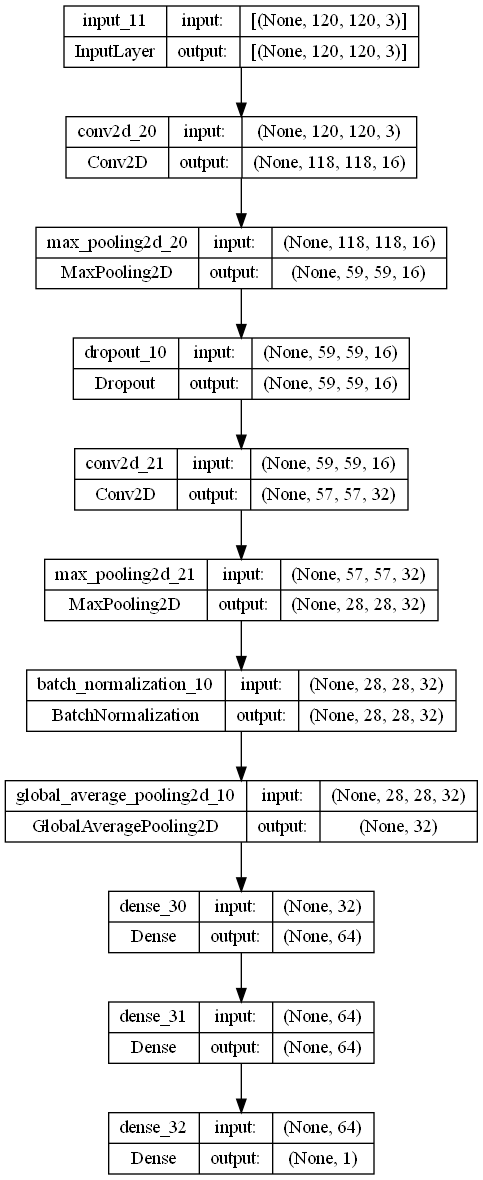

In [84]:
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)